In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def adaptive_sumd(df, min_window=20, max_window=60):
    """
    改进3：动态窗口调整机制
    金融逻辑：不同波动率环境需要不同时间窗口
    改进点：根据波动率自动调整最优窗口大小
    """
    close = df['close']
    price_diff = close.diff()
    
    # 计算波动率特征
    volatility = price_diff.abs().rolling(max_window).std()
    
    # 修复1：处理NaN和inf值
    # 计算波动率均值，使用min_periods=1避免初始NaN
    vol_mean = volatility.rolling(50, min_periods=1).mean()
    # 避免分母为零
    vol_mean = vol_mean.replace(0, 1e-12)
    # 处理剩余NaN
    vol_mean = vol_mean.fillna(1e-12)
    
    # 计算窗口比例
    window_ratio = volatility / vol_mean
    # 修复2：处理可能的inf值
    window_ratio = window_ratio.replace([np.inf, -np.inf], 0)
    
    # 计算窗口大小
    window_size = min_window + window_ratio * (max_window - min_window)
    # 修复3：使用round().astype()替代直接astype()，并处理NaN
    window_size = window_size.fillna(min_window).clip(min_window, max_window)
    window = window_size.round().astype(int)
    
    # 动态窗口计算
    gain = price_diff.where(price_diff > 0, 0)
    loss = (-price_diff).where(price_diff < 0, 0)
    
    # 修复4：使用自定义滚动计算避免NaN
    sum_gain = pd.Series(np.nan, index=gain.index)
    sum_loss = pd.Series(np.nan, index=loss.index)
    
    for i in range(len(gain)):
        w = window.iloc[i] if i >= min_window else min_window
        start_idx = max(0, i - w + 1)
        sum_gain.iloc[i] = gain.iloc[start_idx:i+1].sum()
        sum_loss.iloc[i] = loss.iloc[start_idx:i+1].sum()
    
    # 自适应标准化
    range_factor = (df['high'] - df['low']).rolling(20, min_periods=1).mean() + 1e-12
    factor = (sum_gain - sum_loss) / range_factor
    
    return factor

# 因子测试

In [5]:
evaluator.set_factor(
    factor_func=adaptive_sumd,
    factor_name='adaptive_sumd'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.013539
   Rank_IC (Spearman): -0.026349
📊 信息比率:
   IR: 0.164121
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130940
   因子列: adaptive_sumd
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


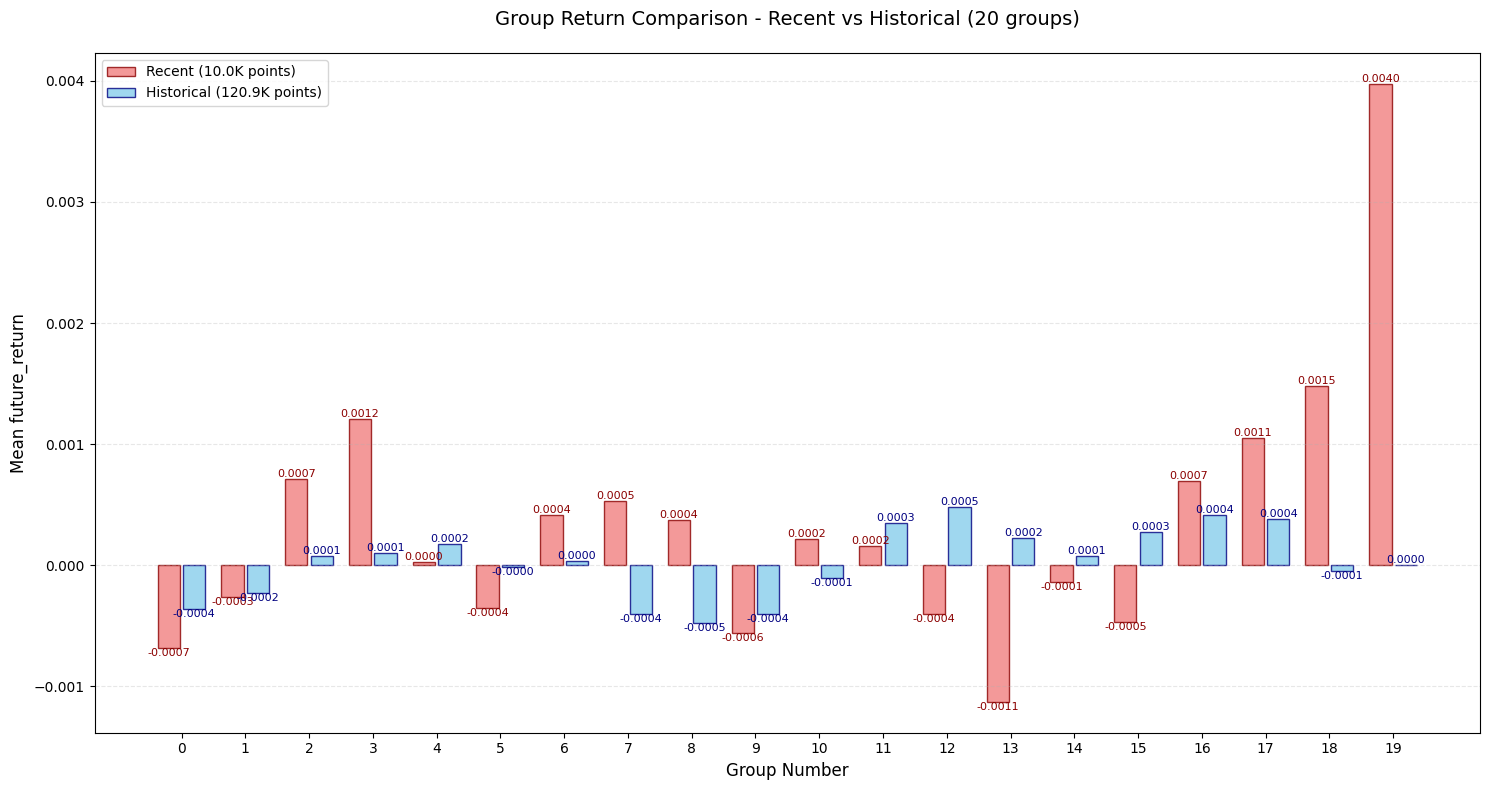

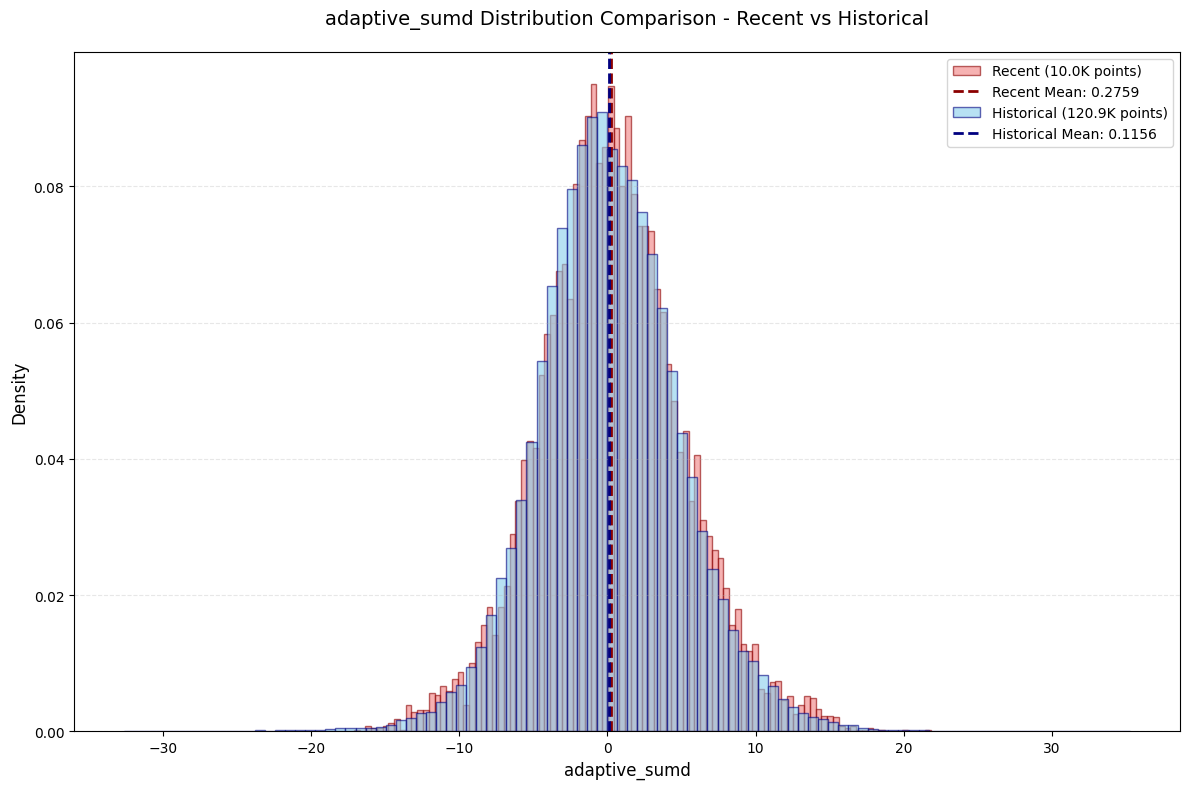

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [6]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [7]:
print(result)

{'correlation_analysis': {'IC': 0.013538826642069445, 'Rank_IC': -0.026349248679814443}, 'information_ratio': {'IR': 0.16412062192244653, 'group_correlations': [0.01282602821795158, 0.0014039205102066052, -0.01473813031040216, -0.014263323177295485, 0.0025447945344063173, 0.020353860873863983, -0.01386486788247338, 0.009819238044627315, 0.004009990564005446, 0.01135318606556888], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0     -32.5867  -7.3995  -10.1321      -0.0004      0.0152   6547
1      -7.3990  -5.5835   -6.4060      -0.0002      0.0141   6547
2      -5.5834  -4.4598   -4.9863       0.0001      0.0128   6547
3      -4.4598  -3.6396   -4.0333       0.0002      0.0122   6547
4      -3.6394  -2.9314   -3.2767       0.0002      0.0118   6547
5      -2.9314  -2.2885   -2.6049      -0.0001      0.0114   6547
6      -2.2883  -1.6853   -1.9834     